# Sampling of Purification MPS
This notebook demonstrates how to sample basis states from a purification MPS to evaluate expectation values. While we demonstrate this for magnetization, a sum of local quantities $\langle Z_i \rangle$, sampling could be useful to stochastically evaluate non-local expectation values where contraction of the tensor network for exact evaluation is expensive. To demonstrate this functionality, we find the purification of the thermal density matrix $\rho \propto e^{-\beta H}$ for the transverse field Ising model as a function of inverse temperature $\beta$. We represent the density matrix as a purified pure state $|\psi \rangle$ on an enlarged Hilbert space $\mathcal{H}_p \otimes \mathcal{H}_a $ such that $\rho = \mathrm{Tr}_a |\psi \rangle \langle \psi |$.

The algorithm from sampling purification MPS is a simple extension of that for sampling MPS, explained in detail in the following two papers:
1. https://arxiv.org/abs/1002.1305
2. https://arxiv.org/abs/1201.3974

In [9]:
import numpy as np
import sys
from time import time

In [3]:
import tenpy
from tenpy.models.tf_ising import TFIChain
from tenpy.networks.purification_mps import PurificationMPS
from tenpy.algorithms.purification import PurificationTEBD, PurificationApplyMPO

Run purification TEBD and measure magnetization on each site, both by contracting the tensor network (really by using orthogonality conditions to avoid most of the work) or sampling.

In [4]:
def imag_tebd(L=30, beta_max=3., dt=0.05, order=2, bc="finite", num_samples=1000):
    model_params = dict(L=L, J=1., g=1.2)
    M = TFIChain(model_params)
    psi = PurificationMPS.from_infiniteT(M.lat.mps_sites(), bc=bc)
    options = {
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-8
        },
        'order': order,
        'dt': dt,
        'N_steps': 1
    }
    beta = 0.
    eng = PurificationTEBD(psi, M, options)
    Szs = [psi.expectation_value("Sz")]
    sample_data = sample_purification(psi, num_samples)
    Szs_sample_sq = [sample_data[0][0]]
    Szs_sample_nsq = [sample_data[1][0]]
    betas = [0.]
    psis = [psi.copy()]
    while beta < beta_max:
        beta += 2. * dt  # factor of 2:  |psi> ~= exp^{- dt H}, but rho = |psi><psi|
        betas.append(beta)
        eng.run_imaginary(dt)  # cool down by dt
        Szs.append(psi.expectation_value("Sz"))  # and further measurements...
        sample_data = sample_purification(psi, num_samples)
        Szs_sample_sq.append(sample_data[0][0])
        Szs_sample_nsq.append(sample_data[1][0])
        psis.append(psi.copy())
    return {'beta': betas, 'Sz': Szs, 'Sz_sample_sq': Szs_sample_sq, 'Sz_sample_nsq': Szs_sample_nsq, 'psi': psis}

Below we repeatedly sample a purification MPS to determine the magnetization. Depending on the value of `sample_q`, we either sample the ancilla leg (`True`) or contract over it (`False`). The first is cheaper than the latter, with a cost of $\mathcal{}(\chi^2)$ compared to $\mathcal{}(\chi^3)$.

In [11]:
def sample_purification(psi, num_samples):
    data = []
    for sample_q in [True, False]:
        magnetization = []
        start_time = time()
        for i in range(num_samples):
            sigmas, total_prob = psi.sample_measurements(sample_q)
            magnetization.append(np.array(sigmas) - 1/2) # 1 index corresponds to spin up I guess
        sample_time = time() - start_time
        magnetization = np.row_stack(magnetization)
        data.append((magnetization.mean(axis=0), magnetization, sample_time))
    return data

In [6]:
import logging
logging.basicConfig(level=logging.INFO)
data_tebd = imag_tebd(L=30, beta_max=3.0, num_samples=100)

INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_

Now let's plot the magnetization as a function of $\beta$. We see that the measurements from sampling agree with those from exact contraction.

/home/sajant/tenpy_sajant/tenpy/tools/params.py:232: UserWarning: unused options for config PurificationTEBD:
['N_steps', 'order']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


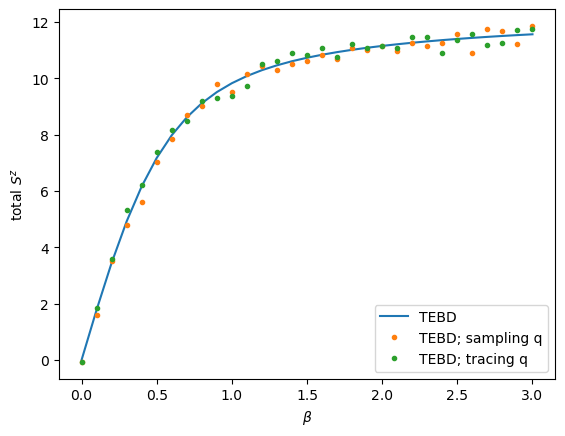

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz'], axis=1), label='TEBD')
plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz_sample_sq'], axis=1), '.', label='TEBD; sampling q')
plt.plot(data_tebd['beta'], np.sum(data_tebd['Sz_sample_nsq'], axis=1), '.', label='TEBD; tracing q')

plt.legend()
plt.xlabel(r'$\beta$')
plt.ylabel(r'total $S^z$')
plt.show()

Finally, we demonstrate that the error in expectation values from sampling decreases with the number of samples, as expected.

In [12]:
data_dict = {}
for ns in [10, 25, 50, 100, 250, 500]:
    data_tebd = imag_tebd(L=30, beta_max=3.0, num_samples=ns)
    data_dict[ns] = data_tebd

INFO:tenpy.tools.params:TFIChain: reading 'L'=30
INFO:tenpy.tools.params:TFIChain: reading 'J'=1.0
INFO:tenpy.tools.params:TFIChain: reading 'g'=1.2
INFO:tenpy.tools.params:PurificationTEBD: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO:tenpy.tools.params:PurificationTEBD: reading 'dt'=0.05
INFO:tenpy.algorithms.tebd:Calculate U for {'order': 2, 'delta_t': 0.05, 'type_evo': 'imag', 'E_offset': None, 'tau': -0.05j}
INFO:tenpy.tools.params:trunc_params: reading 'chi_max'=100
INFO:tenpy.tools.params:trunc_params: reading 'svd_min'=1e-08
INFO:tenpy.algorithms.purification:--> beta=0.050000, E_bond=-0.2460708907, max(S)=0.0172500676
INFO:tenpy.algorithms.purification:--> beta=0.100000, E_bond=-0.4756494810, max(S)=0.0532230133
INFO:tenpy.algorithms.purification:--> beta=0.150000, E_bond=-0.6767971387, max(S)=0.0967049734
INFO:tenpy.algorithms.purification:--> beta=0.200000, E_bond=-0.8441540463, max(S)=0.1411322525
INFO:tenpy.algorithms.purification:--> beta=0.250000, E_

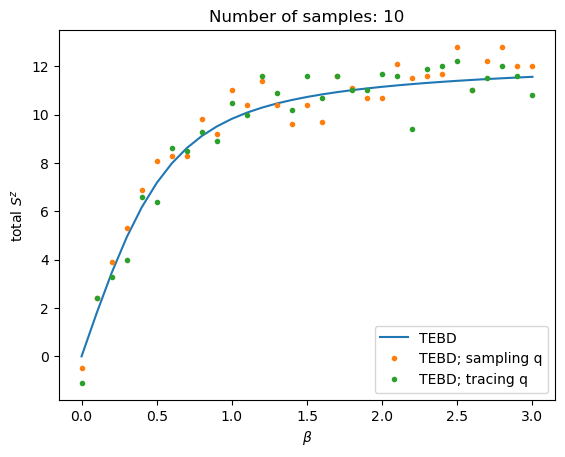

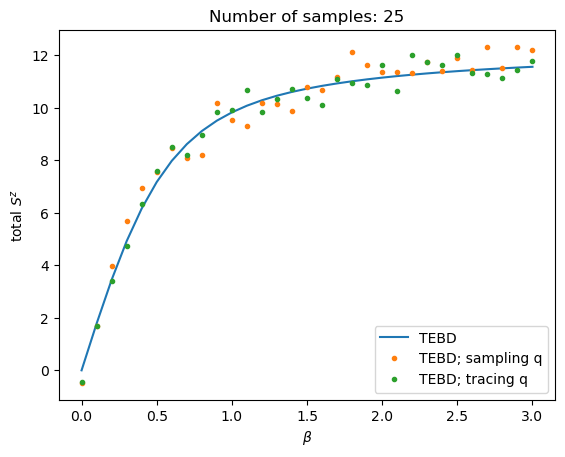

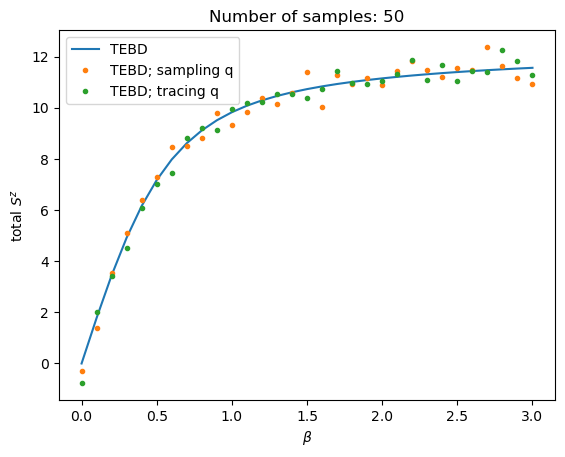

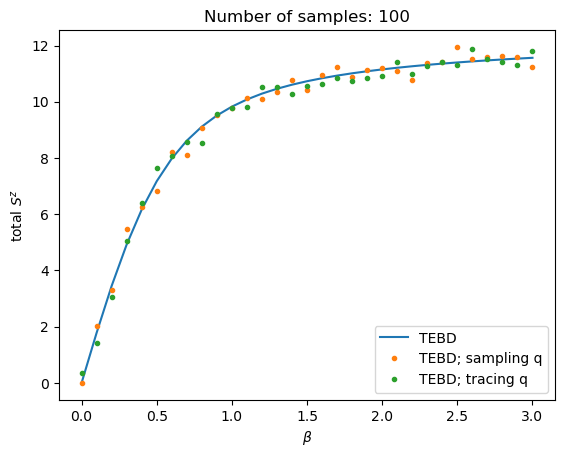

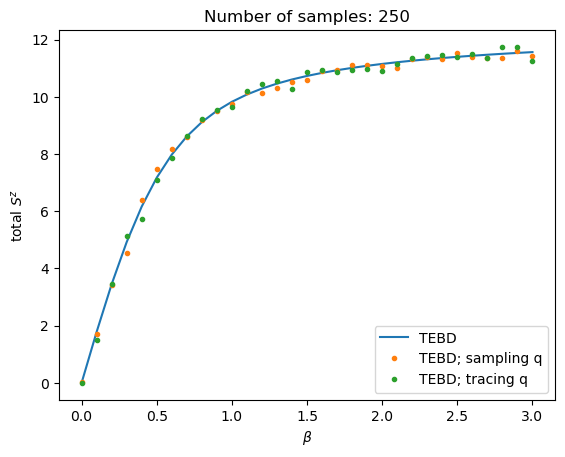

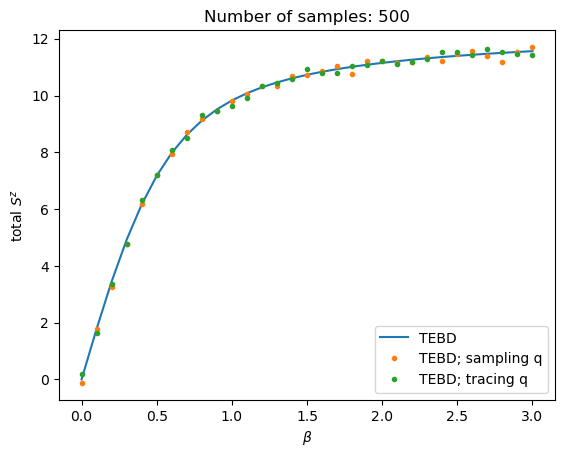

In [13]:
for ns in [10, 25, 50, 100, 250, 500]:
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz'], axis=1), label='TEBD')
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz_sample_sq'], axis=1), '.', label='TEBD; sampling q')
    plt.plot(data_dict[ns]['beta'], np.sum(data_dict[ns]['Sz_sample_nsq'], axis=1), '.', label='TEBD; tracing q')
    
    plt.legend()
    plt.xlabel(r'$\beta$')
    plt.ylabel(r'total $S^z$')
    plt.title(f"Number of samples: {ns}")
    plt.show()

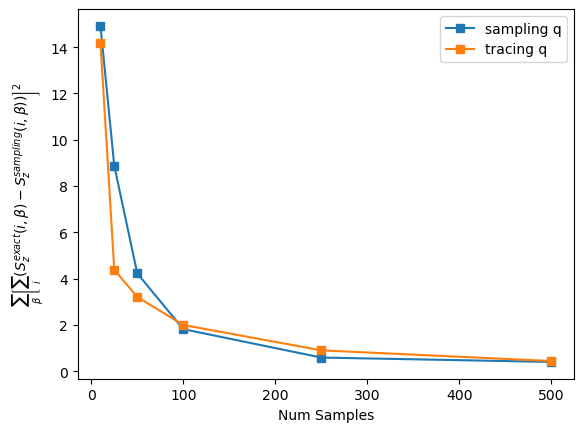

In [38]:
plt.plot([10, 25, 50, 100, 250, 500], 
         [np.power(np.sum(data_dict[ns]['Sz'], axis=1) - np.sum(data_dict[ns]['Sz_sample_sq'], axis=1), 2).sum() for ns in[10, 25, 50, 100, 250, 500]],
        marker='s', label='sampling q')
plt.plot([10, 25, 50, 100, 250, 500], 
         [np.power(np.sum(data_dict[ns]['Sz'], axis=1) - np.sum(data_dict[ns]['Sz_sample_nsq'], axis=1), 2).sum() for ns in[10, 25, 50, 100, 250, 500]],
        marker='s', label='tracing q')

plt.legend()
plt.xlabel(r'Num Samples')
plt.ylabel(r'$\sum_\beta \left[\sum_i (S_z^{exact}(i,\beta) - S_z^{sampling}(i,\beta))\right]^2$')
plt.show()
